In [1]:
"""
Created on Wed Jan 10 17:13:16 2024
@author: Wu Yuxuan
"""

import os
import warnings

import pandas as pd
import anndata as ad
import scanpy as sc
import seaborn as sns
import numpy as np
from matplotlib import rc_context
from matplotlib import pyplot as plt
# import pca from sklearn
from sklearn.decomposition import PCA

/tmp/ipykernel_3558/1699213236.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
seed = 123
warnings.simplefilter(action='ignore', category=FutureWarning)
# info
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

-----
anndata     0.10.5.post1
scanpy      0.1.dev3254+g5b9bc72
-----
PIL                 10.2.0
asttokens           NA
comm                0.2.1
cycler              0.12.1
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7
decorator           5.1.1
executing           2.0.1
h5py                3.10.0
igraph              0.11.3
ipykernel           6.29.0
jedi                0.19.1
joblib              1.3.2
kiwisolver          1.4.5
leidenalg           0.10.2
llvmlite            0.41.1
matplotlib          3.8.3
mpl_toolkits        NA
natsort             8.4.0
numba               0.58.1
numpy               1.26.4
packaging           23.2
pandas              2.2.0
parso               0.8.3
patsy               0.5.6
pexpect             4.9.0
pickleshare         0.7.5
pkg_resources       NA
platformdirs        4.1.0
prompt_toolkit      3.0.42
psutil              5.9.0
ptyprocess          0.7.0
pure_eval           0.2.2
pydev_ipython       NA
pydevconsole        NA
py

In [3]:
os.chdir('/home/wu/datb1/reseq_ppp')

if "adata_all" in locals():
    del adata_all

sample_list = os.listdir("first_stage_insight")
sample_list = [i for i in sample_list if (i.startswith("PPP") or i.startswith("HC")) and i.endswith("10X")]

# load data
for sample in sample_list:
    # if "P40" in sample:
    #     continue
    print(sample)
    sample_path = os.path.join("first_stage_insight", sample, "filtered_feature_bc_matrix")
    if not os.path.exists(sample_path):
        sample_path = os.path.join("first_stage_insight", sample)
    adata = sc.read_10x_mtx(sample_path, cache=True)
    print(adata.shape)
    adata.obs['batch'] = sample
    adata.obs_names = [sample + '_' + i for i in adata.obs_names]
    adata.obs_names_make_unique()
    # if adata_all is already defined, concat the new adata to it
    if 'adata_all' in locals():
        adata_all = ad.concat([adata_all, adata], uns_merge='unique')
    else:
        adata_all = adata.copy()
        adata_all.uns['batch'] = []
        adata_all.uns['batch_raw'] = {}
    adata_all.uns['batch'].append(sample)
    adata_all.uns['batch_raw'][sample] = len(adata.obs_names)

PPP_P16_foot_10X
... reading from cache file cache/first_stage_insight-PPP_P16_foot_10X-filtered_feature_bc_matrix-matrix.h5ad
(2813, 33694)
PPPC_P38C2_palm_10X
... reading from cache file cache/first_stage_insight-PPPC_P38C2_palm_10X-filtered_feature_bc_matrix-matrix.h5ad
(5685, 33694)
PPPC_P39C_palm_10X
... reading from cache file cache/first_stage_insight-PPPC_P39C_palm_10X-filtered_feature_bc_matrix-matrix.h5ad
(5954, 33694)
HC_HC01_foot_10X
... reading from cache file cache/first_stage_insight-HC_HC01_foot_10X-filtered_feature_bc_matrix-matrix.h5ad
(1490, 33694)
PPP_P18_palm_10X
... reading from cache file cache/first_stage_insight-PPP_P18_palm_10X-filtered_feature_bc_matrix-matrix.h5ad
(4547, 33694)
HC_HC02_palm_10X
... reading from cache file cache/first_stage_insight-HC_HC02_palm_10X-filtered_feature_bc_matrix-matrix.h5ad
(8631, 33694)
PPP_P36_foot_10X
... reading from cache file cache/first_stage_insight-PPP_P36_foot_10X-filtered_feature_bc_matrix-matrix.h5ad
(4098, 33694)
PPP

### step 1: filter cells and genes

In [4]:
adata_all

AnnData object with n_obs × n_vars = 68336 × 33694
    obs: 'batch'
    uns: 'batch', 'batch_raw'

filtered out 6469 cells that have less than 300 genes expressed
filtered out 14990 genes that are detected in less than 50 cells
normalizing counts per cell
    finished (0:00:00)


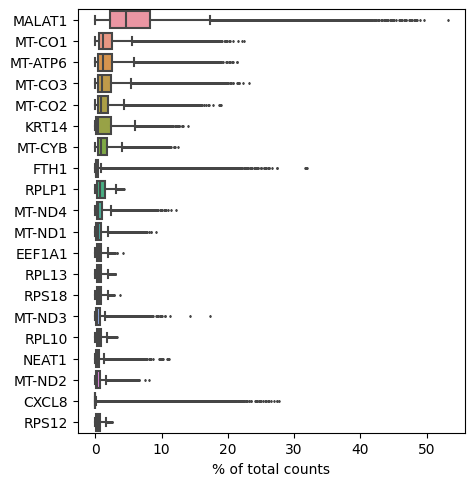

In [5]:
sc.pp.filter_cells(adata_all, min_genes=300)
sc.pp.filter_genes(adata_all, min_cells=50)

sc.pl.highest_expr_genes(adata_all, n_top=20, )

In [6]:
adata_all.var['mt'] = adata_all.var_names.str.startswith('MT-')
adata_all.var['ribo'] = adata_all.var_names.str.startswith(('RPL', 'RPS'))

sc.pp.calculate_qc_metrics(adata_all, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)

array([[<Axes: title={'center': 'pct_counts_mt'}>]], dtype=object)

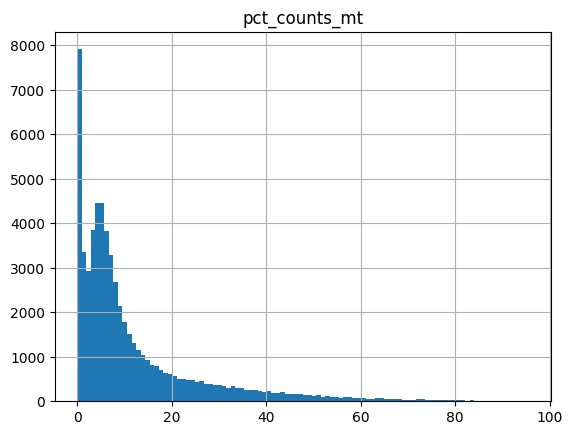

In [7]:
adata_all.obs.hist(column='pct_counts_mt', bins=100)

In [8]:
adata_all.obs.groupby('batch').median()

n_genes  n_genes_by_counts  total_counts  \
batch                                                           
HC_HC01_foot_10X      1152.0             1148.0        2693.0   
HC_HC02_palm_10X      1646.0             1644.0        4432.0   
PPPC_P37C1_palm_10X   1286.5             1284.5        3794.5   
PPPC_P37C2_palm_10X   1850.0             1848.0        6247.0   
PPPC_P38C1_palm_10X   1307.5             1306.0        3962.5   
PPPC_P38C2_palm_10X   1256.0             1255.0        3695.0   
PPPC_P39C_palm_10X    1400.0             1398.5        4218.5   
PPP_P16_foot_10X      1592.0             1589.0        3736.0   
PPP_P17_palm_10X      1796.0             1792.0        4222.0   
PPP_P18_palm_10X      1130.0             1129.0        2572.5   
PPP_P24_foot_10X       825.0              824.0        1771.0   
PPP_P36_foot_10X       527.0              527.0        1000.0   
PPP_P37_palm_10X      1379.0             1378.0        4044.0   
PPP_P38_palm_10X      1227.0             1227.0        3441.5   
PPP_P39_palm_10X      1655.0             1653.0        5179.5   
PPP_P40_palm_10X      1185.0             1184.0        3330.5   

                     total_counts_mt  pct_counts_mt  total_counts_ribo  \
batch                                                                    
HC_HC01_foot_10X               131.0       4.576635              404.0   
HC_HC02_palm_10X               399.0       6.580087              862.0   
PPPC_P37C1_palm_10X            399.0       9.360903              476.5   
PPPC_P37C2_palm_10X            851.0       8.836131             1338.0   
PPPC_P38C1_palm_10X            700.0       9.557815              652.5   
PPPC_P38C2_palm_10X            625.0       9.261088              620.0   
PPPC_P39C_palm_10X             783.5      10.935372              617.5   
PPP_P16_foot_10X               347.0       7.057942              446.0   
PPP_P17_palm_10X               270.0       5.807771              544.0   
PPP_P18_palm_10X               194.0       4.833867              533.0   
PPP_P24_foot_10X               156.0       5.888106              389.0   
PPP_P36_foot_10X                31.0       2.828188              191.0   
PPP_P37_palm_10X               391.0       7.009804              554.0   
PPP_P38_palm_10X               233.0       6.072753              545.0   
PPP_P39_palm_10X               471.5       5.768080              731.5   
PPP_P40_palm_10X                96.0       2.251021              293.5   

                     pct_counts_ribo  
batch                                 
HC_HC01_foot_10X           15.312176  
HC_HC02_palm_10X           22.103910  
PPPC_P37C1_palm_10X        16.161711  
PPPC_P37C2_palm_10X        25.115284  
PPPC_P38C1_palm_10X        20.853836  
PPPC_P38C2_palm_10X        21.526470  
PPPC_P39C_palm_10X         19.654907  
PPP_P16_foot_10X           11.850454  
PPP_P17_palm_10X           12.601625  
PPP_P18_palm_10X           23.045605  
PPP_P24_foot_10X           24.654961  
PPP_P36_foot_10X           20.475193  
PPP_P37_palm_10X           14.486207  
PPP_P38_palm_10X           17.186710  
PPP_P39_palm_10X           19.641771  
PPP_P40_palm_10X           11.286497

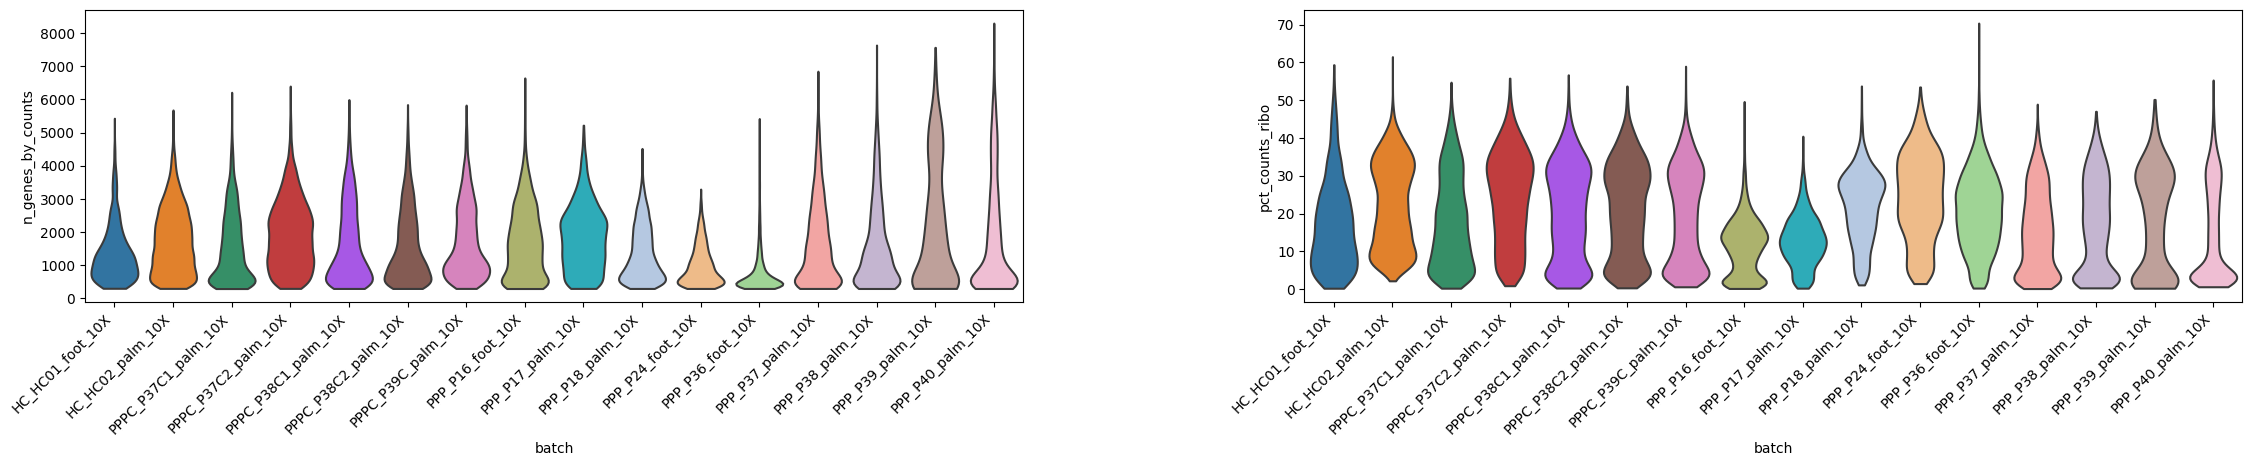

In [9]:
with rc_context({'figure.figsize': (10, 4)}):
    ax = sc.pl.violin(adata_all, ['n_genes_by_counts', 'pct_counts_ribo'], stripplot=False, groupby='batch', show=False)
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right')
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right')

<Axes: xlabel='pct_counts_ribo', ylabel='Count'>

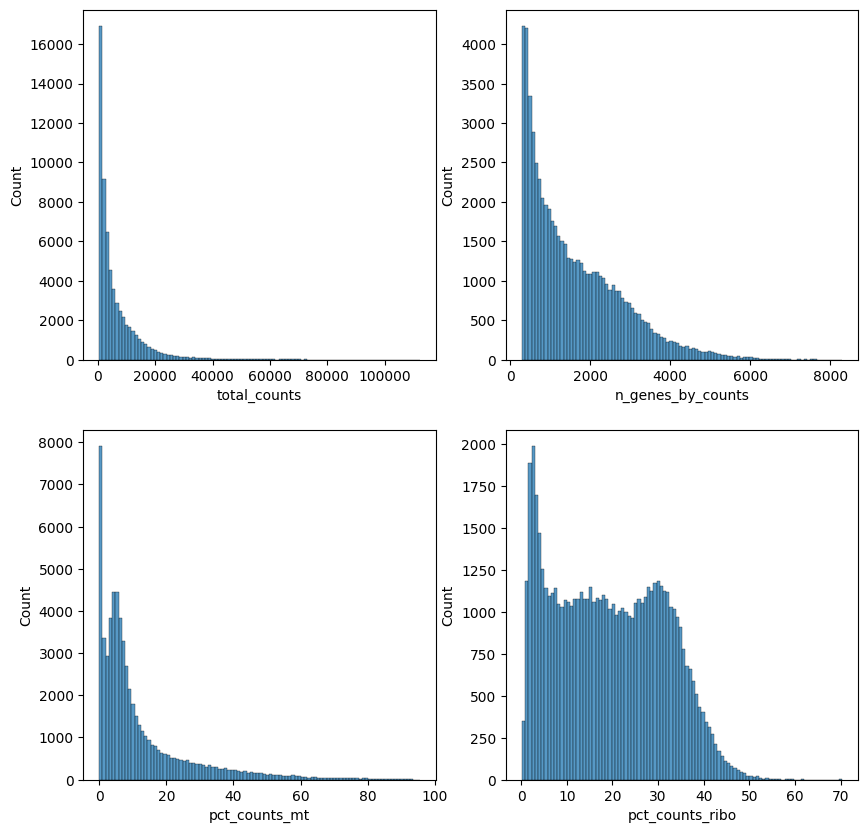

In [10]:
# histplot
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

sns.histplot(adata_all.obs['total_counts'], bins=100, ax=axs[0, 0])
sns.histplot(adata_all.obs['n_genes_by_counts'], bins=100, ax=axs[0, 1])
sns.histplot(adata_all.obs['pct_counts_mt'], bins=100, ax=axs[1, 0])
sns.histplot(adata_all.obs['pct_counts_ribo'], bins=100, ax=axs[1, 1])

In [11]:
# filter out cells of more than 40% percent mitochondrial genes
adata_all = adata_all[adata_all.obs.pct_counts_mt < 40, :]
adata_all = adata_all[adata_all.obs.total_counts < 30000, :]

adata_all
# save the raw data
adata_all.write("processed_data/ALL_PPP_10X_raw.h5ad")

In [12]:
adata_all.obs

batch  n_genes  \
PPP_P16_foot_10X_AAACCCAAGCCTTTCC-1  PPP_P16_foot_10X     2106   
PPP_P16_foot_10X_AAACCCAAGTACTCGT-1  PPP_P16_foot_10X      688   
PPP_P16_foot_10X_AAACCCAAGTGCCGAA-1  PPP_P16_foot_10X     1548   
PPP_P16_foot_10X_AAACCCAGTGGCCTCA-1  PPP_P16_foot_10X     1685   
PPP_P16_foot_10X_AAACCCATCATACGAC-1  PPP_P16_foot_10X     1730   
...                                               ...      ...   
PPP_P24_foot_10X_TTTGGTTTCAAATAGG-1  PPP_P24_foot_10X     2270   
PPP_P24_foot_10X_TTTGGTTTCCATCACC-1  PPP_P24_foot_10X     1211   
PPP_P24_foot_10X_TTTGGTTTCTGTCAGA-1  PPP_P24_foot_10X      425   
PPP_P24_foot_10X_TTTGTTGTCTCAGGCG-1  PPP_P24_foot_10X     1240   
PPP_P24_foot_10X_TTTGTTGTCTCATGGA-1  PPP_P24_foot_10X      354   

                                     n_genes_by_counts  total_counts  \
PPP_P16_foot_10X_AAACCCAAGCCTTTCC-1               2102        5001.0   
PPP_P16_foot_10X_AAACCCAAGTACTCGT-1                688        1815.0   
PPP_P16_foot_10X_AAACCCAAGTGCCGAA-1               1543        3928.0   
PPP_P16_foot_10X_AAACCCAGTGGCCTCA-1               1679        4216.0   
PPP_P16_foot_10X_AAACCCATCATACGAC-1               1719        4138.0   
...                                                ...           ...   
PPP_P24_foot_10X_TTTGGTTTCAAATAGG-1               2268        9767.0   
PPP_P24_foot_10X_TTTGGTTTCCATCACC-1               1210        2593.0   
PPP_P24_foot_10X_TTTGGTTTCTGTCAGA-1                423         753.0   
PPP_P24_foot_10X_TTTGTTGTCTCAGGCG-1               1240        4354.0   
PPP_P24_foot_10X_TTTGTTGTCTCATGGA-1                347         672.0   

                                     total_counts_mt  pct_counts_mt  \
PPP_P16_foot_10X_AAACCCAAGCCTTTCC-1            416.0       8.318336   
PPP_P16_foot_10X_AAACCCAAGTACTCGT-1            141.0       7.768595   
PPP_P16_foot_10X_AAACCCAAGTGCCGAA-1            982.0      25.000000   
PPP_P16_foot_10X_AAACCCAGTGGCCTCA-1            773.0      18.334915   
PPP_P16_foot_10X_AAACCCATCATACGAC-1            616.0      14.886418   
...                                              ...            ...   
PPP_P24_foot_10X_TTTGGTTTCAAATAGG-1            451.0       4.617590   
PPP_P24_foot_10X_TTTGGTTTCCATCACC-1            168.0       6.478981   
PPP_P24_foot_10X_TTTGGTTTCTGTCAGA-1            163.0      21.646748   
PPP_P24_foot_10X_TTTGTTGTCTCAGGCG-1            198.0       4.547543   
PPP_P24_foot_10X_TTTGTTGTCTCATGGA-1            202.0      30.059523   

                                     total_counts_ribo  pct_counts_ribo  
PPP_P16_foot_10X_AAACCCAAGCCTTTCC-1              526.0        10.517897  
PPP_P16_foot_10X_AAACCCAAGTACTCGT-1              382.0        21.046833  
PPP_P16_foot_10X_AAACCCAAGTGCCGAA-1              125.0         3.182281  
PPP_P16_foot_10X_AAACCCAGTGGCCTCA-1               59.0         1.399431  
PPP_P16_foot_10X_AAACCCATCATACGAC-1              224.0         5.413243  
...                                                ...              ...  
PPP_P24_foot_10X_TTTGGTTTCAAATAGG-1             3427.0        35.087540  
PPP_P24_foot_10X_TTTGGTTTCCATCACC-1              419.0        16.158890  
PPP_P24_foot_10X_TTTGGTTTCTGTCAGA-1               63.0         8.366534  
PPP_P24_foot_10X_TTTGTTGTCTCAGGCG-1             1596.0        36.655949  
PPP_P24_foot_10X_TTTGTTGTCTCATGGA-1               58.0         8.630952  

[56600 rows x 8 columns]

### step 2: normalize and scale

/home/wu/scanpy/scanpy/preprocessing/_normalization.py:167: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:03:37)
extracting highly variable genes
    finished (0:00:14)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/wu/scanpy/scanpy/preprocessing/_highly_variable_genes.py:212: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


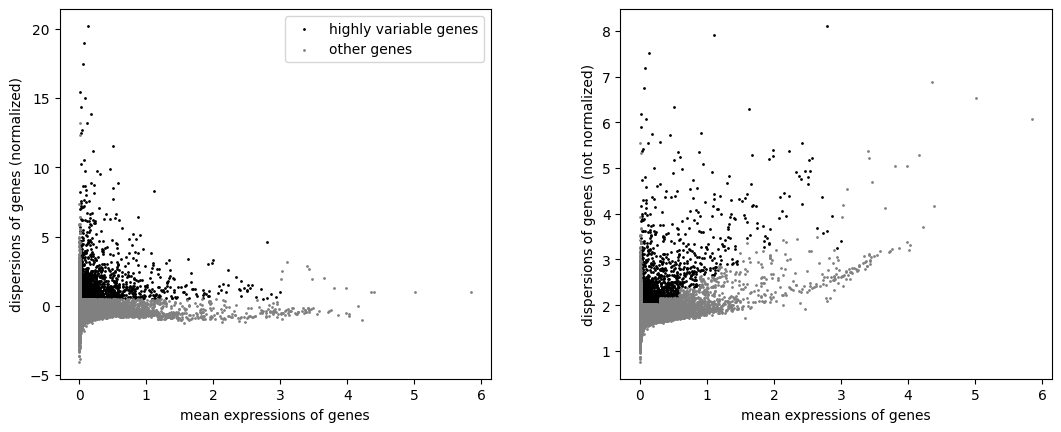

In [13]:
sc.pp.normalize_total(adata_all, target_sum=1e4)
sc.pp.log1p(adata_all)

# keep raw normalized data
adata_all.raw = adata_all

sc.pp.regress_out(adata_all, ['total_counts', 'pct_counts_mt'], n_jobs=4, add_intercept=True)

sc.pp.highly_variable_genes(adata_all, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata_all)

sc.pp.scale(adata_all, max_value=10)

### step 3: PCA and clustering

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:18)


/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


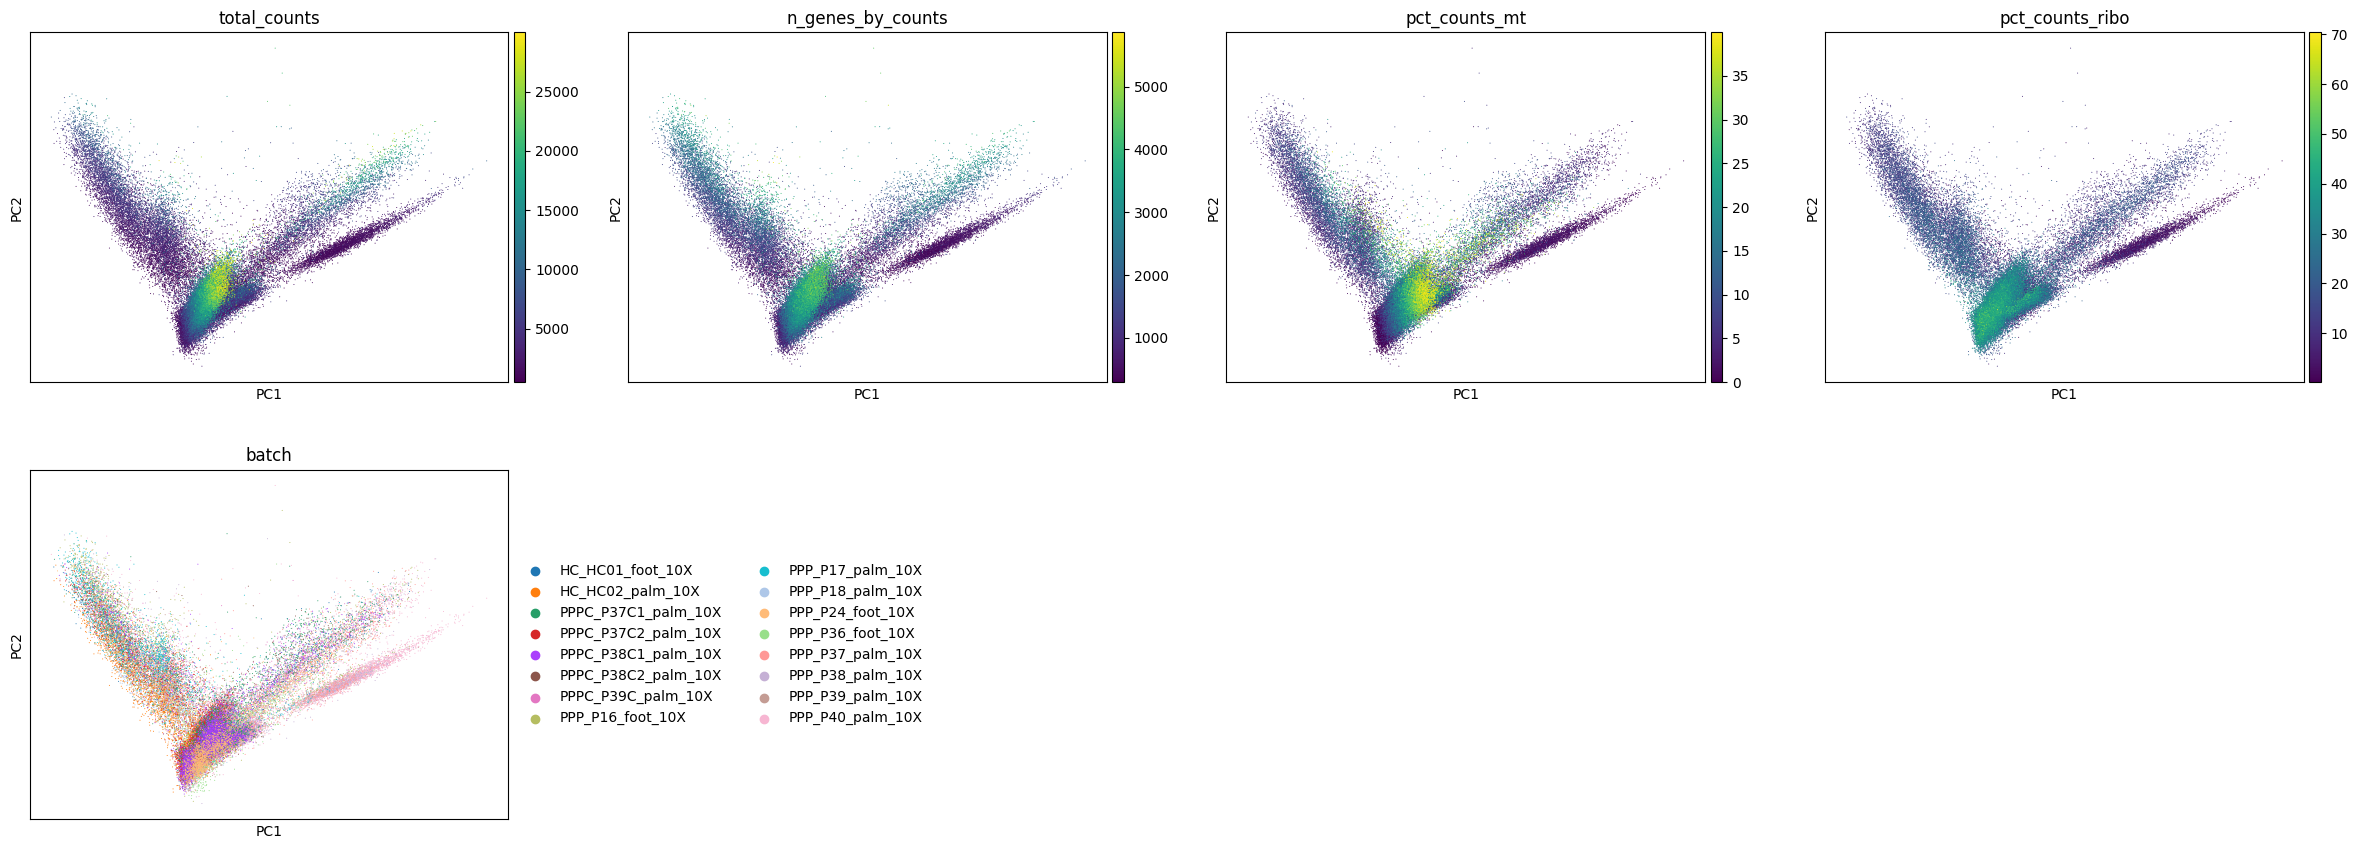

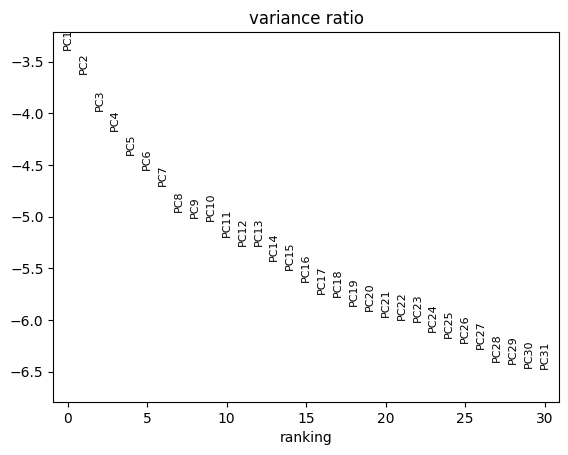

computing neighbors
    using 'X_pca' with n_pcs = 40


/home/wu/mambaforge/envs/github_scanpy/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:26)


In [14]:
sc.tl.pca(adata_all, svd_solver='arpack', random_state=seed)
sc.pl.pca(adata_all, color=['total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'pct_counts_ribo', 'batch'])

sc.pl.pca_variance_ratio(adata_all, log=True)

sc.pp.neighbors(adata_all, n_neighbors=10, n_pcs=40, random_state=seed)

In [15]:
# # Copy adata not to modify UMAP in the original adata object
# adata_temp=adata_all.copy()
# # Loop through different umap parameters, recomputting and replotting UMAP for each of them
# for min_dist in [0.1,0.5,1,2]:
#     for spread in [0.5,1,2,5]:
#         param_str=' '.join(['min_dist =',str(min_dist),'and spread =',str(spread)])
#         sc.tl.umap(adata_temp, min_dist=min_dist, spread=spread)
#         # Display plot and then immediately close it to ensure that
#         # we do not open too many plot windows at once
#         g=sc.pl.umap(adata_temp,title=param_str,s=40,color='leiden',
#                    show=False, return_fig=True)
#         display(g)
#         plt.close()
# del adata_temp

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:19)


/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


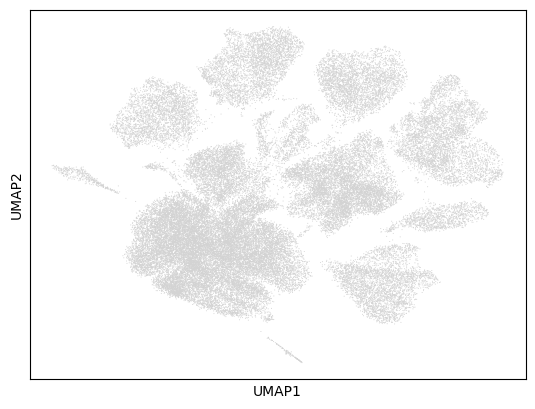

In [16]:
sc.tl.umap(adata_all, random_state=seed, min_dist=0.5, spread=0.5)
sc.pl.umap(adata_all)

In [17]:
adata_all.obs

batch  n_genes  \
PPP_P16_foot_10X_AAACCCAAGCCTTTCC-1  PPP_P16_foot_10X     2106   
PPP_P16_foot_10X_AAACCCAAGTACTCGT-1  PPP_P16_foot_10X      688   
PPP_P16_foot_10X_AAACCCAAGTGCCGAA-1  PPP_P16_foot_10X     1548   
PPP_P16_foot_10X_AAACCCAGTGGCCTCA-1  PPP_P16_foot_10X     1685   
PPP_P16_foot_10X_AAACCCATCATACGAC-1  PPP_P16_foot_10X     1730   
...                                               ...      ...   
PPP_P24_foot_10X_TTTGGTTTCAAATAGG-1  PPP_P24_foot_10X     2270   
PPP_P24_foot_10X_TTTGGTTTCCATCACC-1  PPP_P24_foot_10X     1211   
PPP_P24_foot_10X_TTTGGTTTCTGTCAGA-1  PPP_P24_foot_10X      425   
PPP_P24_foot_10X_TTTGTTGTCTCAGGCG-1  PPP_P24_foot_10X     1240   
PPP_P24_foot_10X_TTTGTTGTCTCATGGA-1  PPP_P24_foot_10X      354   

                                     n_genes_by_counts  total_counts  \
PPP_P16_foot_10X_AAACCCAAGCCTTTCC-1               2102        5001.0   
PPP_P16_foot_10X_AAACCCAAGTACTCGT-1                688        1815.0   
PPP_P16_foot_10X_AAACCCAAGTGCCGAA-1               1543        3928.0   
PPP_P16_foot_10X_AAACCCAGTGGCCTCA-1               1679        4216.0   
PPP_P16_foot_10X_AAACCCATCATACGAC-1               1719        4138.0   
...                                                ...           ...   
PPP_P24_foot_10X_TTTGGTTTCAAATAGG-1               2268        9767.0   
PPP_P24_foot_10X_TTTGGTTTCCATCACC-1               1210        2593.0   
PPP_P24_foot_10X_TTTGGTTTCTGTCAGA-1                423         753.0   
PPP_P24_foot_10X_TTTGTTGTCTCAGGCG-1               1240        4354.0   
PPP_P24_foot_10X_TTTGTTGTCTCATGGA-1                347         672.0   

                                     total_counts_mt  pct_counts_mt  \
PPP_P16_foot_10X_AAACCCAAGCCTTTCC-1            416.0       8.318336   
PPP_P16_foot_10X_AAACCCAAGTACTCGT-1            141.0       7.768595   
PPP_P16_foot_10X_AAACCCAAGTGCCGAA-1            982.0      25.000000   
PPP_P16_foot_10X_AAACCCAGTGGCCTCA-1            773.0      18.334915   
PPP_P16_foot_10X_AAACCCATCATACGAC-1            616.0      14.886418   
...                                              ...            ...   
PPP_P24_foot_10X_TTTGGTTTCAAATAGG-1            451.0       4.617590   
PPP_P24_foot_10X_TTTGGTTTCCATCACC-1            168.0       6.478981   
PPP_P24_foot_10X_TTTGGTTTCTGTCAGA-1            163.0      21.646748   
PPP_P24_foot_10X_TTTGTTGTCTCAGGCG-1            198.0       4.547543   
PPP_P24_foot_10X_TTTGTTGTCTCATGGA-1            202.0      30.059523   

                                     total_counts_ribo  pct_counts_ribo  
PPP_P16_foot_10X_AAACCCAAGCCTTTCC-1              526.0        10.517897  
PPP_P16_foot_10X_AAACCCAAGTACTCGT-1              382.0        21.046833  
PPP_P16_foot_10X_AAACCCAAGTGCCGAA-1              125.0         3.182281  
PPP_P16_foot_10X_AAACCCAGTGGCCTCA-1               59.0         1.399431  
PPP_P16_foot_10X_AAACCCATCATACGAC-1              224.0         5.413243  
...                                                ...              ...  
PPP_P24_foot_10X_TTTGGTTTCAAATAGG-1             3427.0        35.087540  
PPP_P24_foot_10X_TTTGGTTTCCATCACC-1              419.0        16.158890  
PPP_P24_foot_10X_TTTGGTTTCTGTCAGA-1               63.0         8.366534  
PPP_P24_foot_10X_TTTGTTGTCTCAGGCG-1             1596.0        36.655949  
PPP_P24_foot_10X_TTTGTTGTCTCATGGA-1               58.0         8.630952  

[56600 rows x 8 columns]

running Leiden clustering
    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


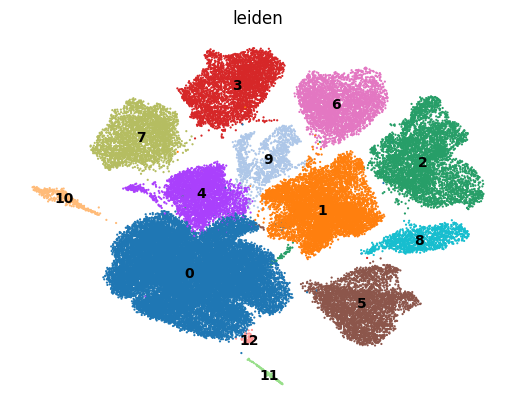

/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


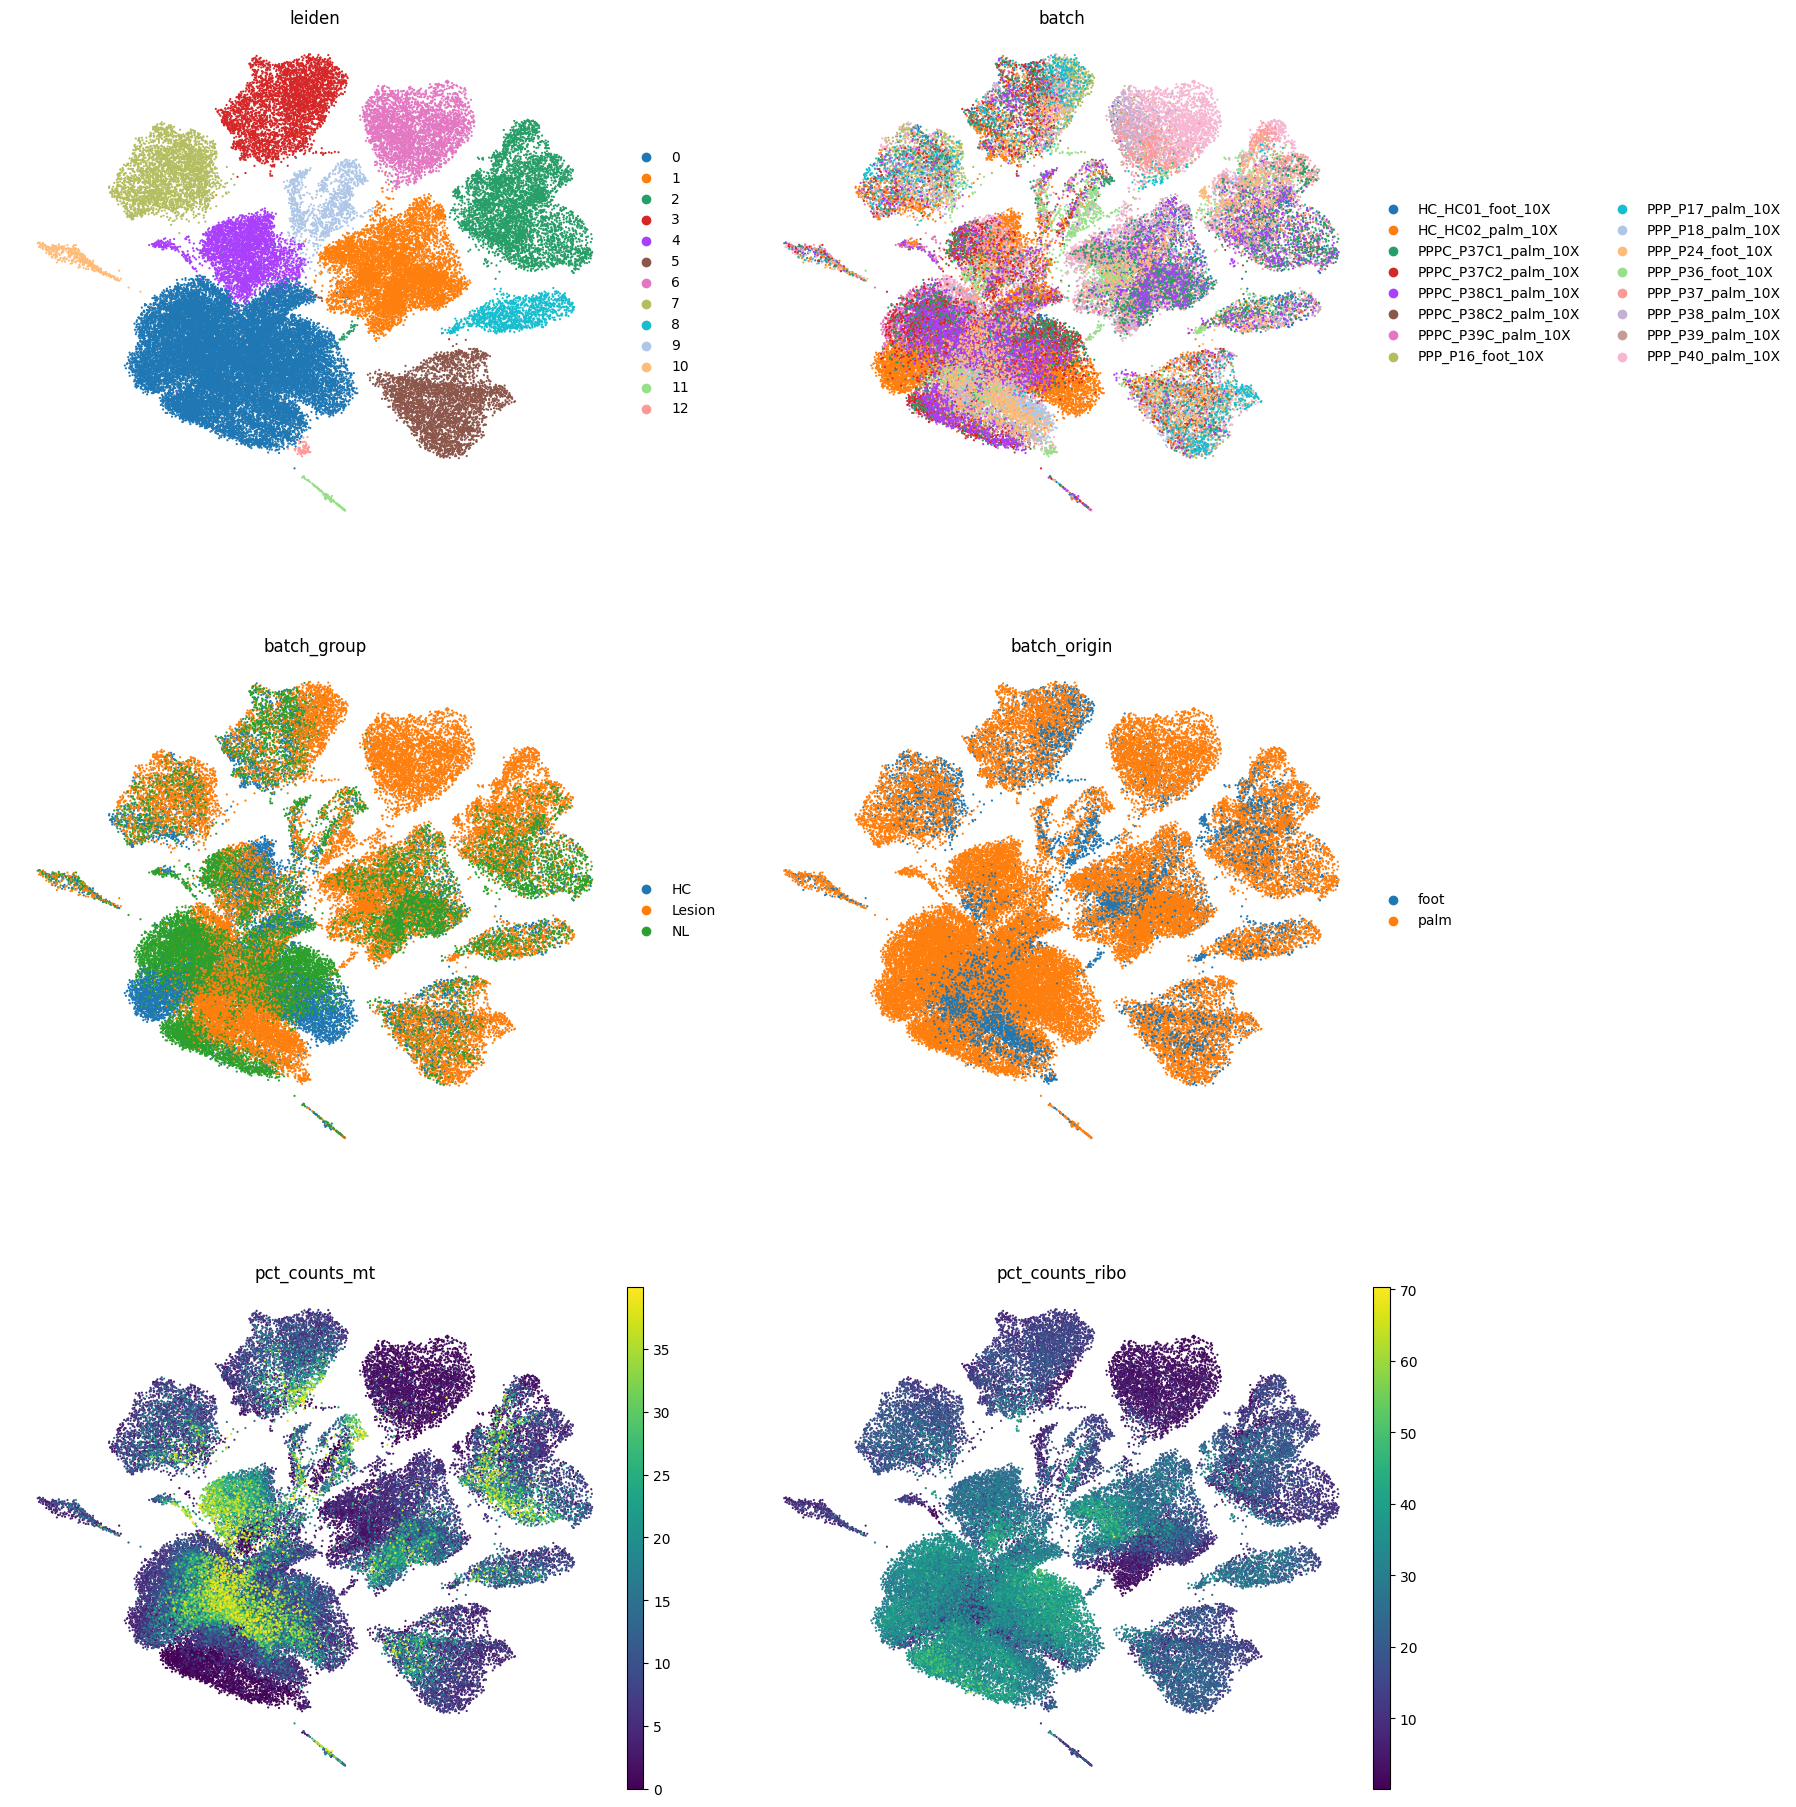

In [18]:
def extract_batch_group(batch):
    if batch.split('_')[0] == 'PPP':
        return 'Lesion'
    elif batch.split('_')[0] == 'HC':
        return 'HC'
    elif batch.split('_')[0] == 'PPPC':
        return 'NL'
    else:
        assert False, "Unknown batch group"

# extract specimen origin from batch
def extract_batch_origin(batch):
    if "palm" in batch:
        return 'palm'
    elif "foot" in batch:  
        return 'foot'
    else:
        return 'unknown'

adata_all.obs['batch_origin'] = adata_all.obs.batch.apply(extract_batch_origin).astype('category')
adata_all.obs['batch_group'] = adata_all.obs.batch.apply(extract_batch_group).astype('category')
adata_all.obs['Meta'] = adata_all.obs['batch_group'].apply(lambda x: 'Lesion' if x == 'Lesion' else 'Control').astype('category')

metadata = pd.read_csv("Pub_PPP_code/charts/metadata.csv")

# update metadata
adata_all.obs = adata_all.obs.join(metadata.set_index('batch'), on='batch', validate='many_to_one').copy()
adata_all.obs

sc.tl.leiden(adata_all, resolution=0.1, random_state=seed)
sc.pl.umap(adata_all, color='leiden', frameon=False, legend_loc='on data', size=10)

with rc_context({'figure.figsize': (8, 7)}):
    sc.pl.umap(adata_all, color=['leiden', 'batch', 'batch_group', 'batch_origin', 'pct_counts_mt', 'pct_counts_ribo'], ncols=2, size=10, frameon=False)


/home/wu/scanpy/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


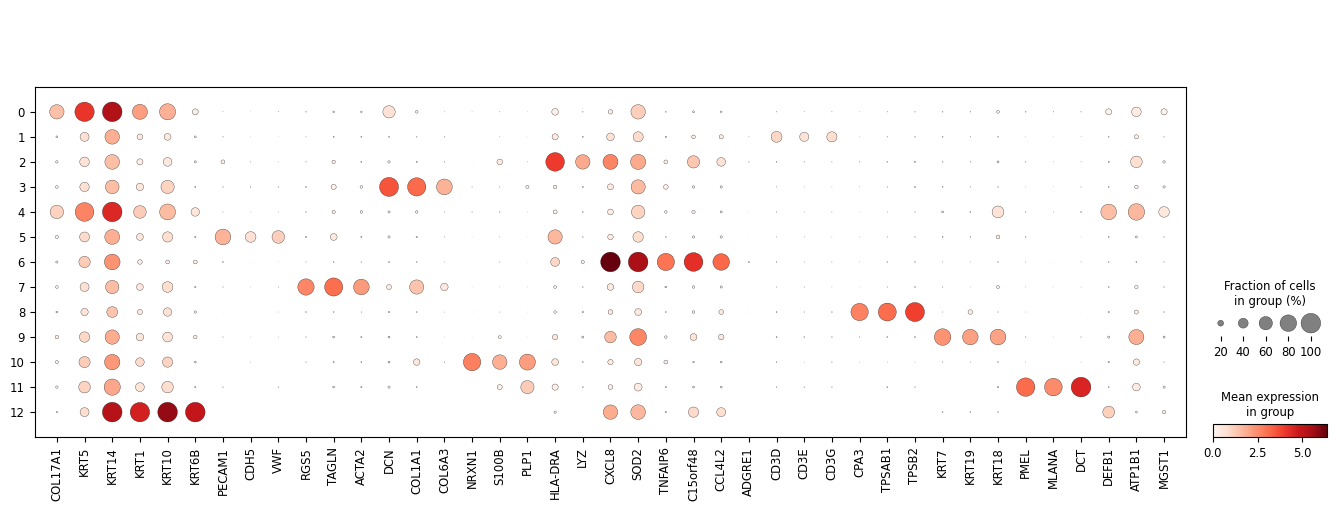

In [19]:
marker_genes = ["COL17A1", "KRT5", "KRT14", "KRT1", "KRT10", "KRT6B", "PECAM1","CDH5","VWF","RGS5","TAGLN","ACTA2","DCN","COL1A1","COL6A3",
             "NRXN1","S100B","PLP1","HLA-DRA", "LYZ", "CXCL8", "SOD2", "TNFAIP6", "C15orf48","CCL4L2","ADGRE1",
             "CD3D","CD3E","CD3G","CPA3","TPSAB1","TPSB2","KRT7","KRT19","KRT18","PMEL", "MLANA", "DCT", "DEFB1", "ATP1B1", "MGST1"]
sc.pl.dotplot(adata_all, marker_genes, groupby='leiden')

/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


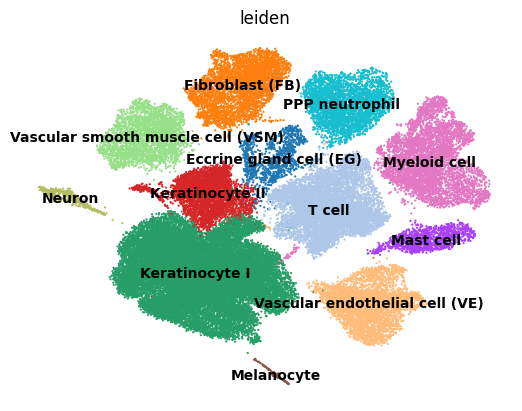

/home/wu/scanpy/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


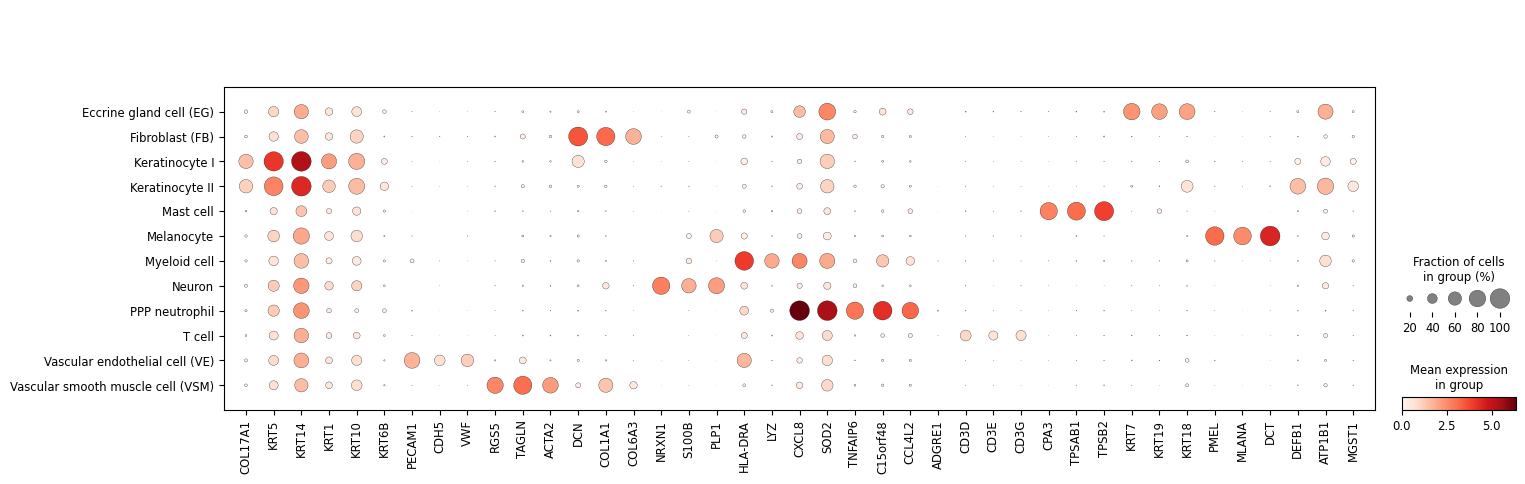

In [20]:
marker_genes = ["COL17A1", "KRT5", "KRT14", "KRT1", "KRT10", "KRT6B", "PECAM1","CDH5","VWF","RGS5","TAGLN","ACTA2","DCN","COL1A1","COL6A3",
             "NRXN1","S100B","PLP1","HLA-DRA", "LYZ", "CXCL8", "SOD2", "TNFAIP6", "C15orf48","CCL4L2","ADGRE1",
             "CD3D","CD3E","CD3G","CPA3","TPSAB1","TPSB2","KRT7","KRT19","KRT18","PMEL", "MLANA", "DCT", "DEFB1", "ATP1B1", "MGST1"]

new_cluster_names = {
    '0': 'Keratinocyte I',
    '1': 'T cell',
    '2': 'Myeloid cell',
    '3': 'Fibroblast (FB)',
    '4': 'Keratinocyte II',
    '5': 'Vascular endothelial cell (VE)',
    '6': 'PPP neutrophil',
    '7': 'Vascular smooth muscle cell (VSM)',
    '8': 'Mast cell',
    '9': 'Eccrine gland cell (EG)',
    '10': 'Neuron',
    '11': 'Melanocyte',
    '12': 'Keratinocyte I',
    # '13': 'Keratinocyte I',
}

adata_all.obs['leiden'] = adata_all.obs['leiden'].map(new_cluster_names).astype('category')
sc.pl.umap(adata_all, color='leiden', frameon=False, legend_loc='on data', size=10)
sc.pl.dotplot(adata_all, marker_genes, groupby='leiden')

In [21]:
adata_all

AnnData object with n_obs × n_vars = 56600 × 18704
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'batch_origin', 'batch_group', 'Meta', 'Gender', 'Age', 'leiden'
    var: 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch', 'batch_raw', 'batch_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'batch_group_colors', 'batch_origin_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [22]:
# save the data
adata_all.write("processed_data/ALL_PPP_10X.h5ad")